In [2]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from scipy.integrate import ode
from sympy import Symbol, Point2D, Point3D, Derivative, Function
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.patches import Polygon, Circle

In [3]:

class SimPlot:
    fig, ax = None, None

    lines = []
    titles = []
    points = []
    vectors = []
    patches = []

    def __init__(self, xlim, ylim):
        self.fig, self.ax = plt.subplots()
        self.ax.set_xlim(xlim[0], xlim[1])
        self.ax.set_ylim(ylim[0], ylim[1])
        self.ax.set_aspect("equal")

    def plot_lines(self, in_lines, in_colors=[]):
        colors = in_colors + ['black'] * (len(in_lines) - len(in_colors))

        self.lines.extend([
            plt.plot([u[0], v[0]], [u[1], v[1]], color=color)
            for [u, v], color in zip(in_lines, colors)
        ])

    def plot_points(self, in_points, in_sizes=[], in_colors=[]):
        colors = in_colors + ['black'] * (len(in_points) - len(in_colors))
        sizes = in_sizes + [3] * (len(in_points) - len(in_sizes))
        
        self.points.extend([
            plt.plot([x], [y], marker='o', markersize=size, color=color)
            for [x, y], size, color in zip(in_points, sizes, colors)
        ])

    def plot_titles(self, coords, titles, ofx=0, ofy=0):
        self.titles.extend([
            self.ax.text(x + ofx, y + ofy, title)
            for [x, y], title in zip(coords, titles)
        ])

    def plot_vectors(self, vectors_u, vectors_v, titles, scale=1, in_colors=[]):
        colors = in_colors + ['black'] * (len(vectors_u) - len(in_colors))
        self.vectors.extend([
            plt.quiver(float(u[0]), float(u[1]), float(v[0]), float(v[1]), color=color, scale=scale, angles='xy', units='xy', scale_units='xy')
            for u, v, color in zip(vectors_u, vectors_v, colors)
        ])

        self.plot_titles([u + v / scale for u, v in zip(vectors_u, vectors_v)], titles)

    def add_patch(self, patch):
        self.ax.add_patch(patch)
        self.patches.append(patch)
    

    def clear_plot(self):
        while len(self.lines):
            self.lines[-1][0].remove()
            self.lines.pop()

        while len(self.titles):
            self.titles[-1].remove()
            self.titles.pop()

        while len(self.points):
            self.points[-1][0].remove()
            self.points.pop()

        while len(self.vectors):
            self.vectors[-1].remove()
            self.vectors.pop()

        while len(self.patches):
            self.patches[-1].remove()
            self.patches.pop()

![](assets/odesolve.PNG)

In [4]:
t = Symbol('t')
x = Function('x')(t)
xi = Function(r'\xi')(t)

In [5]:
ce = 0.000108108 * t

In [6]:
x = 5.96046 * 1e-8 * sp.exp(-ce) * (4.94278 * 1e15 - 4.94278 * 1e15 * sp.exp(ce) + sp.exp(2 * ce) + 5.34354 * 1e11 * sp.exp(ce) * t)
xi = 4.24352 * sp.exp(-ce) * (-6.0125 * 1e7 + 6.0125 * 1e7 * sp.exp(ce) + 7.02301 * 1e-9 * sp.exp(2 * ce) - 6499.29 * sp.exp(ce) * t + sp.exp(ce) * t**2)

In [7]:
display(x, xi)

5.96046e-8*(534354000000.0*t*exp(0.000108108*t) - 4.94278e+15*exp(0.000108108*t) + exp(0.000216216*t) + 4.94278e+15)*exp(-0.000108108*t)

4.24352*(t**2*exp(0.000108108*t) - 6499.29*t*exp(0.000108108*t) + 60125000.0*exp(0.000108108*t) + 7.02301e-9*exp(0.000216216*t) - 60125000.0)*exp(-0.000108108*t)

![](assets/reduce.PNG)

In [8]:
t_end = 0.47

In [10]:
A = Point2D(x * sp.cos(sp.pi / 6), -x * sp.sin(sp.pi / 6))
B = Point2D(A[0] + sp.sqrt(3) * sp.cos(sp.pi / 6), A[1] - sp.sqrt(3) * sp.sin(sp.pi / 6))
C = Point2D(A[0] + sp.cos(sp.pi / 3), A[1] + sp.sin(sp.pi / 3))
M = Point2D(C[0] + xi * sp.cos(sp.pi / 3), C[1] - xi * sp.sin(sp.pi / 3))

In [29]:
r = 0.25

In [30]:
O1 = Point2D(((B - A) / 4 + A)[0] - r * sp.cos(sp.pi / 3), ((B - A) / 4 + A)[1] - r * sp.sin(sp.pi / 3))
O2 = Point2D((3 * (B - A) / 4 + A)[0] - r * sp.cos(sp.pi / 3), (3 * (B - A) / 4 + A)[1] - r * sp.sin(sp.pi / 3))

In [42]:
W1 = Point2D(O1[0] + r * sp.cos(-sp.diff(x) / r), O1[1] + r * sp.sin(-sp.diff(x) / r))
W2 = Point2D(O2[0] + r * sp.cos(-sp.diff(x) / r), O2[1] + r * sp.sin(-sp.diff(x) / r))

In [50]:
L1 = Point2D(-2 * r * sp.cos(sp.pi / 3), -2 * r * sp.sin(sp.pi / 3))
L2 = Point2D(-2 * r * sp.cos(sp.pi / 3) + 2.5 * sp.cos(sp.pi / 6), -2 * r * sp.sin(sp.pi / 3) - 2.5 * sp.sin(sp.pi / 6))
L3 = Point2D(L1[0], L2[1])

In [51]:
model = SimPlot([-1, 2], [-2, 1])

model.ax.axis('off')

ln, = plt.plot([], [], 'b--')

def update_anim(frame):
    [A_frame, B_frame, C_frame] = [P.subs(t, frame).evalf() for P in [A, B, C]]
    M_frame = M.subs(t, frame).evalf()
    [O1_frame, O2_frame] = [P.subs(t, frame).doit().evalf() for P in [O1, O2]]
    [W1_frame, W2_frame] = [P.subs(t, frame).doit().evalf() for P in [W1, W2]]
    [L1_frame, L2_frame, L3_frame] = [P.subs(t, frame).doit().evalf() for P in [L1, L2, L3]]

    model.clear_plot()

    model.add_patch(Polygon([A_frame, B_frame, C_frame], fill=False, hatch='//'))
    model.add_patch(Circle(O1_frame, r, fill=False, color='black'))
    model.add_patch(Circle(O2_frame, r, fill=False, color='black'))
    model.plot_lines([[W1_frame, O1_frame], [W2_frame, O2_frame], [L1_frame, L2_frame], [L2_frame, L3_frame]])
    model.plot_points([M_frame], in_sizes=[5], in_colors=['red'])
    model.plot_titles([M_frame], ['M'], ofx=0.05)
    return ln,

t_end = float(t_end)
frames = np.linspace(0, t_end, 100)

anim = FuncAnimation(model.fig, update_anim, frames=frames, blit=True)
anim.save('model.gif', dpi=100, writer=PillowWriter(fps=60))
plt.close('all')

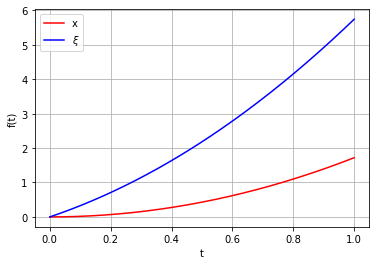

In [55]:
fig = plt.subplot()

plt.xlabel('t')
plt.ylabel('f(t)')

frames = np.linspace(0, 1, 200)
xs = [x.subs(t, frame) for frame in frames]
xis = [xi.subs(t, frame) for frame in frames]

plt.plot(frames, xs, color='red', label='x')
plt.plot(frames, xis, color='blue', label=r'$\xi$')

plt.grid()
plt.legend()
plt.savefig('xsxis.png')